<a href="https://colab.research.google.com/github/AminTaheri23/Deep-Persian-NER/blob/master/Amin_Taheri_DeepNLp_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About Final Project
### In this project, your task is to build and train a model to recognize Named Entities from a  sentence. This model should give a tag to each word from a sentence. A classical application is Named Entity Recognition (NER)
## Named Entity Recognition (NER)

 Named Entity Recognition is a process where an algorithm takes a string of text (sentence or paragraph) as input and identifies relevant nouns (people, places,  organizations, and...) that are mentioned in that string. Here is an example:




```
John  went to New   York  to interview with Microsoft 
B-PER O    O  B-LOC I-LOC O  O         O    B-ORG
```



# images

# ArmanPersoNERCorpus
### https://github.com/HaniehP/PersianNER
This dataset includes 250,015 tokens and 7,682 Persian sentences in total. Each file contains one token, along with its manually annotated named-entity tag, per line. Each sentence is separated with a newline. The NER tags are in IOB format. 

The IOB format (short for inside, outside, beginning) is a common tagging format for tagging tokens in a chunking task in computational linguistics (ex. named entity recognition)

An example with IOB format:




```
John B-PER
lives O
in O
New B-LOC
York I-LOC
. O

This O
is O
another O
sentence
```



 In ArmanPersoNERCorpus, NEs are categorized into six classes:***person*** , ***organization*** (such as banks, ministries, embassies, teams, nationalities, networks and publishers),***location*** (such as cities, villages, rivers, seas, gulfs, deserts and mountains), ***facility*** (such as schools, universities, research centers, airports, railways, bridges, roads, harbors, stations, hospitals, parks, zoos and cinemas), ***product*** (such as books, newspapers, TV shows, movies, airplanes, ships, cars, theories, laws, agreements and religions), and ***event*** (such as wars, earthquakes, national holidays, festivals and conferences); other are the remaining tokens.

#Implementation

## Importing libraries

In [1]:
import sys, os, re, codecs
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.layers import GRU, SimpleRNN
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc
from gensim.models import KeyedVectors
import gensim
import pandas as pd
import numpy as np

Using TensorFlow backend.


## Mounting your Google Drive files in Google Colab

In [2]:
from google.colab import drive
drive.mount('/Mydrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /Mydrive


#Preprocessing steps

###Define list classes in our dataset

In [0]:
list_classes = ['B-pers','I-pers', 'B-pro', 'I-pro','B-loc','I-loc','B-fac','I-fac','B-event','I-event','B-org','I-org','O']
list_columns = ['text','label']

### Convert labels to one-hot vectors

In [0]:
def label_to_one_hot(value):
  list_classes = ['B-pers','I-pers', 'B-pro', 'I-pro','B-loc','I-loc','B-fac','I-fac','B-event','I-event','B-org','I-org','O']
  if value == list_classes[0]:
    return [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[1]:
    return [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[2]:
    return [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[3]:
    return [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[4]:
    return [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[5]:
    return [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[6]:
    return [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  if value == list_classes[7]:
    return [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  if value == list_classes[8]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  if value == list_classes[9]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  if value == list_classes[10]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  if value == list_classes[11]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  if value == list_classes[12]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


### Read  train data file

In [0]:
def read_data(filename):
    df= pd.DataFrame(columns=list_columns)
    
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')        
        sentence.append([splits[0], splits[-1]])

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
        
    for sentence in sentences:
      text=''
      words=[]
      values=[]
      for item in sentence:
        words.append(item[0])
        values.append(item[1].replace('\n',''))
      _list=[]
      _list.append(' '.join(words))
      _list.append(' '.join(values))
      df2 = pd.DataFrame([_list], columns=list_columns)
      df=df.append(df2, ignore_index=True)
    return df

In [0]:
train = read_data('/Mydrive/My Drive/Colab Notebooks/mycorpus/ArmanPersoNERCorpus.txt')

In [7]:
train.head()

,text,label
0,به عنوان مثال وقتی نشریات مدافع اصول و ارزشها ...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,دکتر اصغری دبیر چهارمین همایش انجمن زمین‌شناسی...,O B-pers O B-event I-event I-event I-event I-e...
2,دکتر اکبر میرعرب در همایش بررسی و پیشگیری از ب...,O B-pers I-pers O B-event I-event I-event I-ev...
3,اردبیل ـ استاندار اردبیل گفت : به مناسبت هفته ...,B-loc O O B-loc O O O O B-event I-event O O O ...
4,حمید طاهایی افزود : برای اجرای این طرحها 0 میل...,B-pers I-pers O O O O O O O O O O O O O O O O O


## Split data, into X and Y sets

In [0]:
y = train['label']
list_sentences_train = train['text']

###Tokenization 

In [0]:
max_features = 250015
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

y = [[label_to_one_hot(c) for c in ey.split(' ')] for ey in y]

## How do you know what is the best "maxlen" to set?
One of the ways to go about it is to see the distribution of the number of words in sentences.

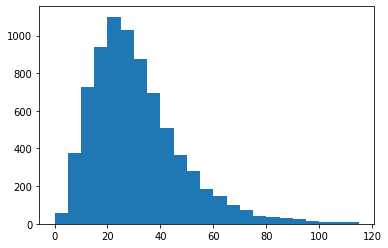

In [10]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,120,5))
plt.show()
# 120 is a good maxlen

##Padding

In [11]:
maxlen = 60
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y_t = pad_sequences(y, maxlen=maxlen)
print(len(X_t[0]))
print(len(y_t[0]))

60
60


##  load our embeddings model into a dictionary 

In [0]:
def loadEmbeddingMatrix(typeToLoad):
    if(typeToLoad=="fasttext"):
        EMBEDDING_FILE='/Mydrive/My Drive/Colab Notebooks/mycorpus/model_fastext_sg.vec'
        embed_size = 300

    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        with open(EMBEDDING_FILE,'r', encoding='utf8')as f:
            for line in f:
                try:
                    values = line.split()

                    if len(values)==301:
                        word = values[0]    
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==302:
          #print(len(value))
                        word = values[0]+'\u200c'+values[1]   
                        coefs = np.asarray(values[2:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==303:
                        word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]  
                        coefs = np.asarray(values[3:], dtype='float32')
                        embeddings_index[word] = coefs
                except Exception as inst:
                        print(inst)
    else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            #print('Loaded %s word vectors.' % len(embeddings_index))
            
    gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
    nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')
        
    del(embeddings_index)
    gc.collect()
        
        #finally, return the embedding matrix
    return embedding_matrix

In [15]:
embedding_matrix = loadEmbeddingMatrix('fasttext')

total embedded: 6553 common words


# installing crf from keras coontibutaions


In [16]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-9lh4d721
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-9lh4d721
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=4b37d314e79de24f35bb4ab0f13dc118f9c84c219005b865bd015b03d4c685d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-l15a5q6n/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


#training steps

##Architectures:

*   word emedding(fasttext-glove-w2v)-Bi-directional LSTM-softmax
*   Bi-directional LSTM-softmax
*   word emedding(fasttext-glove-w2v)-Bi-directional LSTM-CRF(Conditional Random Field)
*   Bi-directional LSTM-CRF
*   word emedding(fasttext-glove-w2v)- Bi-directional LSTM-CNNs-CRF
*   Bi-directional LSTM-CNNs-CRF

##building  your models

### Bi-directinal LSTM-softmax(pretrained)



In [0]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential

model = Sequential()
# model.add(Dense(shape=(maxlen,)))
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
                    weights=[embedding_matrix],trainable=False ))
model.add(Bidirectional(LSTM(150, return_sequences=True,
                             name='lstm_layer',dropout=0.1,recurrent_dropout=0.1)))
model.add(Dense(13, activation='softmax'))

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         5462400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 300)         541200    
_________________________________________________________________
dense_4 (Dense)              (None, None, 13)          3913      
Total params: 6,007,513
Trainable params: 545,113
Non-trainable params: 5,462,400
_________________________________________________________________


### Bi-directinal LSTM-softmax



In [0]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential

model = Sequential()
# model.add(Dense(shape=(maxlen,)))
model.add(Embedding(max_features+1, 300, input_length=maxlen))
model.add(Bidirectional(LSTM(150, return_sequences=True,
                             name='lstm_layer',dropout=0.1,recurrent_dropout=0.1)))
model.add(Dense(13, activation='softmax'))

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 60, 300)           75004800  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60, 300)           541200    
_________________________________________________________________
dense_5 (Dense)              (None, 60, 13)            3913      
Total params: 75,549,913
Trainable params: 75,549,913
Non-trainable params: 0
_________________________________________________________________


### bi-Directional lstm, crf (wordembedding)
the other architectures are commented in this cell, i can also make them in separete cells, but i tthoght this is more straight forward. 

In [0]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential

model = Sequential()
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))
model.add(CRF(13, sparse_target=True) )  # CRF layer

model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_accuracy])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 300)         5462400   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 60)          79440     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 60)          21840     
_________________________________________________________________
crf_3 (CRF)                  (None, None, 13)          988       
Total params: 5,564,668
Trainable params: 102,268
Non-trainable params: 5,462,400
_________________________________________________________________


### bi-Directional lstm, crf 
the other architectures are commented in this cell, i can also make them in separete cells, but i tthoght this is more straight forward. 

In [0]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential

model = Sequential()
# model.add(Input(shape=(maxlen,)))
model.add(Embedding(max_features+1, 300, input_length=maxlen))
# model.add(Masking(mask_value=)
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))

model.add(CRF(13, sparse_target=True) )  # CRF layer, n_tags+1(PAD)

model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_accuracy])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 60, 300)           75004800  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 60, 60)            79440     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 60, 60)            21840     
_________________________________________________________________
crf_2 (CRF)                  (None, 60, 13)            988       
Total params: 75,107,068
Trainable params: 75,107,068
Non-trainable params: 0
_________________________________________________________________


### bi-lstm, cnn, crf (WordEmbedding)
the other architectures are commented in this cell, i can also make them in separete cells, but i tthoght this is more straight forward. 

In [0]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential

model = Sequential()
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))
model.add(Conv1D(60, 1, activation='relu'))
model.add(MaxPooling1D(1))
model.add(Conv1D(60, 1, activation='relu'))
model.add(MaxPooling1D(1))# global max pooling
model.add(CRF(13, sparse_target=True))  # CRF layer,

model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_accuracy])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 300)         5462400   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 60)          79440     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, None, 60)          21840     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 60)          3660      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 60)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 60)          3660      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 60)        

### bi-lstm, cnn, crf 
the other architectures are commented in this cell, i can also make them in separete cells, but i tthoght this is more straight forward. 

In [0]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential

model = Sequential()
model.add(Embedding(max_features+1, 300, input_length=maxlen))
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))
model.add(Conv1D(60, 1, activation='relu'))
model.add(MaxPooling1D(1))
model.add(Conv1D(60, 1, activation='relu'))
model.add(MaxPooling1D(1))# global max pooling
model.add(CRF(13, sparse_target=True))  # CRF layer,

model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_accuracy])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 60, 300)           75004800  
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 60, 60)            79440     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 60, 60)            21840     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 60, 60)            3660      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 60, 60)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 60, 60)            3660      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 60, 60)          

### my state of the art

In [0]:
from tensorflow import keras
import tensorflow.keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [42]:
from keras.layers import  TimeDistributed
from keras.layers.merge import add
inp = Input(shape=(maxlen, ))
emb = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(150, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(emb)
x_rnn = Bidirectional(LSTM(150, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = add([x, x_rnn]) 
#x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(300, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(13, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', get_f1])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 60, 300)      5462400     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 60, 300)      541200      embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 60, 300)      541200      bidirectional_7[0][0]            
____________________________________________________________________________________________

##Fit your models

In [46]:
batch_size = 512
epochs = 5
hist = model.fit(X_t[:7400],y_t[:7400], batch_size=batch_size, epochs=epochs, validation_split=0.2, )#class_weight={'O':0.04, 'B-pers':0.20}) 

Train on 5920 samples, validate on 1480 samples
Epoch 1/5
5920/5920 [==============================] - 38s 6ms/step - loss: 0.1013 - accuracy: 0.9763 - get_f1: 0.6399 - val_loss: 0.0778 - val_accuracy: 0.9901 - val_get_f1: 0.8701
Epoch 2/5
5920/5920 [==============================] - 36s 6ms/step - loss: 0.0750 - accuracy: 0.9908 - get_f1: 0.8847 - val_loss: 0.0747 - val_accuracy: 0.9912 - val_get_f1: 0.8873
Epoch 3/5
5920/5920 [==============================] - 36s 6ms/step - loss: 0.0735 - accuracy: 0.9915 - get_f1: 0.8929 - val_loss: 0.0738 - val_accuracy: 0.9913 - val_get_f1: 0.8890
Epoch 4/5
5920/5920 [==============================] - 36s 6ms/step - loss: 0.0724 - accuracy: 0.9915 - get_f1: 0.8931 - val_loss: 0.0728 - val_accuracy: 0.9912 - val_get_f1: 0.8874
Epoch 5/5
5920/5920 [==============================] - 36s 6ms/step - loss: 0.0714 - accuracy: 0.9914 - get_f1: 0.8928 - val_loss: 0.0722 - val_accuracy: 0.9911 - val_get_f1: 0.8866


##training/validation loss plots

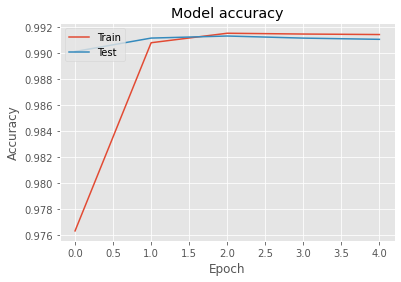

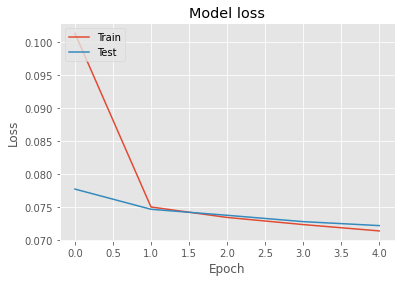

In [47]:
# Visualize the Model
plt.style.use("ggplot")
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Fill the table for all architectures

<table>
<thead>
<tr>
<th></th>
<th align="center"><code>        </code></th>
<th align="center"><code>loss</code></th>
<th align="center"><code>        </code></th>
<th align="center"><code>accuracy</code></th>
<th align="center"><code>        </code></th>
<th align="center"><code>val_loss</code></th>
<th align="center"><code>        </code></th>
<th align="center"><code>val_accuracy</code></th>
<th align="center"><code>        </code></th>
</tr>
</thead>
<tbody>
<tr>
<td>word emedding-Bi-directional LSTM-softmax</td>
 <td align="center"> </td>
<td align="center">0.0726</td>
<td align="center"> </td>
<td align="center">0.9915</td>
<td align="center"> </td>
<td align="center">0.0722</td>
<td align="center"> </td>
<td align="center">0.9915</td>
<td align="center"> </td>
</tr>
<tr>
<td>Bi-directional LSTM-softmax</td>
  <td align="center"> </td>
<td align="center">0.0677</td>
<td align="center"> </td>
<td align="center">0.9917</td>
<td align="center"></td>
  <td align="center">0.0675</td>
<td align="center"> </td>
<td align="center">0.9918</td>
<td align="center"> </td>
</tr>
<tr>
<td>word emedding-Bi-directional LSTM-CRF</td>
  <td align="center"> </td>
<td align="center">0.0418</td>
<td align="center"> </td>
<td align="center">0.9933</td>
<td align="center"> </td>
 <td align="center">0.0363</td>
<td align="center"> </td>
<td align="center">0.9941</td>
<td align="center"> </td>
</tr>
<tr>
<td>Bi-directional LSTM-CRF</td>
  <td align="center"> </td>
<td align="center">0.0348</td>
<td align="center"> </td>
<td align="center">0.9932</td>
<td align="center"></td>
 <td align="center">0.0290</td>
<td align="center"> </td>
<td align="center">0.9941</td>
<td align="center"> </td>
</tr>
<tr>
<td>word emedding- Bi-directional LSTM-CNNs-CRF</td>
  <td align="center"> </td>
<td align="center">0.0382</td>
<td align="center"></td>
<td align="center">0.9933</td>
<td align="center"></td>
<td align="center">0.0324</td>
<td align="center"> </td>
<td align="center">0.9941</td>
<td align="center"> </td>
</tr>
<tr>
<td>Bi-directional LSTM-CNNs-CRF</td>
  <td align="center"> </td>
<td align="center">0.0330</td>
<td align="center"></td>
<td align="center">0.9933</td>
<td align="center"></td>
<td align="center">0.0281</td>
<td align="center"></td>
<td align="center">0.9941</td>
<td align="center"></td>
</tr>

<td>my state of the art lstm </td>
<td align="center"> </td>
<td align="center">0.0717</td>
<td align="center"></td>
<td align="center">0.9915</td>
<td align="center"></td>
<td align="center">0.0704</td>
<td align="center"></td>
<td align="center">0.9917</td>
<td align="center"></td>
</tr>
</tbody>
</table>